In [1]:
from huggingface_hub import login
login()

In [2]:
# Установка зависимостей
!pip install -U peft trl bitsandbytes rouge_score accelerate datasets transformers huggingface_hub wandb evaluate mlflow --quiet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.8/410.8 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 335.7/335.7 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 109.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.2/28.2 MB 70.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 98.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 19.1 MB/s eta 0:00:00

In [3]:
# === Настройка wandb ===
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: veronika-zaslavskaya (veronika-zaslavskaya-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model
from trl import setup_chat_format, DataCollatorForCompletionOnlyLM, SFTTrainer
from datasets import load_dataset
import wandb
import torch
import mlflow
from pprint import pprint

In [5]:
# Load tokenizer and model
model_name = "openlm-research/open_llama_3b_v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    load_in_8bit=True  # 8-bit quantization for memory efficiency
)

# Apply LoRA adapters
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    lora_dropout=0.05,
    target_modules=["q_proj", "v_proj"]
)
model = get_peft_model(model, lora_config)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/593 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/512k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/330 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggin

config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


pytorch_model.bin:   0%|          | 0.00/6.85G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [6]:
# Настройка QLoRA
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)

# Загрузка модели и токенизатора
model_name = "unsloth/Llama-3.2-1B-Instruct"
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    attn_implementation="eager"
)
tokenizer = AutoTokenizer.from_pretrained(model_name)
if hasattr(tokenizer, "chat_template") and tokenizer.chat_template is not None:
    tokenizer.chat_template = None

model, tokenizer = setup_chat_format(model, tokenizer)
tokenizer.padding_side = 'right'
tokenizer.pad_token = tokenizer.eos_token

config.json:   0%|          | 0.00/949 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.7k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


In [7]:
dataset = load_dataset("csv", data_files={"train": "questions_answers.csv"})["train"]
dataset = dataset.train_test_split(test_size=0.1)

pprint(dataset["train"][0])

Generating train split: 0 examples [00:00, ? examples/s]

{'anchor': "If I inject more, there won't be any room for the blood to go "
           'through the rest of his body.',
 'response': "You're right. Let's make damn sure we don't damage his toes "
             'while we blow up his heart.'}


In [8]:
from evaluate import load
bleu = load("bleu")
rouge = load("rouge")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    result = {
        "bleu": bleu.compute(predictions=decoded_preds, references=decoded_labels)["bleu"],
        "rougeL": rouge.compute(predictions=decoded_preds, references=decoded_labels)["rougeL"]
    }
    return result

In [9]:
peft_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=['up_proj', 'down_proj', 'gate_proj', 'k_proj', 'q_proj', 'v_proj', 'o_proj']
)
model = get_peft_model(model, peft_config)


In [16]:
# from transformers import TrainingArguments

wandb.init(project="housemd-chatbot-llama3", name="llama3-lora_v3_ext_chat_template", sync_tensorboard=True)

# training_arguments = TrainingArguments(
#     output_dir="output-llama3",
#     per_device_train_batch_size=1,
#     per_device_eval_batch_size=4,
#     gradient_accumulation_steps=2,
#     num_train_epochs=2,
#     optim="paged_adamw_32bit",
#     eval_strategy="steps",
#     eval_steps=50,
#     logging_steps=100,
#     warmup_steps=10,
#     learning_rate=2e-4,
#     bf16=True,
#     group_by_length=True,
#     logging_dir='./logs',
#     report_to="none",  # или ["mlflow"] если используешь
#     run_name="Llama3-finetuned",
# )


training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=4,
    learning_rate=2e-4,
    num_train_epochs=1,
    logging_steps=25,
    evaluation_strategy="steps",  # 👈
    eval_steps=500,
    save_strategy="steps",        # 👈
    save_steps=500,               # 👈 нужно явно указать save_steps, если save_strategy="steps"
    save_total_limit=1,
    metric_for_best_model="eval_loss",
    bf16=True,
    report_to=["wandb", "mlflow"],
    run_name="llama3-lora_v3_ext_chat_template",
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [13]:
# 💬 Функция для форматирования в chat_template
def format_chat_template(example):
    messages = [
        {"role": "user", "content": example["anchor"]},
        {"role": "assistant", "content": example["response"]}
    ]
    return tokenizer.apply_chat_template(messages, tokenize=False)


In [17]:
print(tokenizer.chat_template)


{% for message in messages %}{{'<|im_start|>' + message['role'] + '
' + message['content'] + '<|im_end|>' + '
'}}{% endfor %}{% if add_generation_prompt %}{{ '<|im_start|>assistant
' }}{% endif %}


In [18]:
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    peft_config=peft_config,
    formatting_func=format_chat_template,
    processing_class=tokenizer,
    # compute_metrics=compute_metrics,
    args=training_args,
)

trainer.train()

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Applying formatting function to train dataset:   0%|          | 0/20054 [00:00<?, ? examples/s]

Converting train dataset to ChatML:   0%|          | 0/20054 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/20054 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/20054 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/20054 [00:00<?, ? examples/s]

Applying formatting function to eval dataset:   0%|          | 0/2229 [00:00<?, ? examples/s]

Converting eval dataset to ChatML:   0%|          | 0/2229 [00:00<?, ? examples/s]

Applying chat template to eval dataset:   0%|          | 0/2229 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/2229 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/2229 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
2025/03/23 14:24:13 ERROR mlflow.utils.async_logging.async_logging_queue: Run Id e139be530e9844078b9a3817ad8501b1: Failed to log run data: Exception: Changing param values is not allowed. Param with key='logging_dir' was already logged with value='./results/runs/Mar23_14-21-01_3d77f789e916' for run ID='e139be530e9844078b9a3817ad8501b1'. Attempted logging new value './results/runs/Mar23_14-23-51_3d77f789e916'.
2025/03/23 14:24:13 ERROR mlflow.utils.async_logging.async_logging_queue: Run Id e139be530e9844078b9a3817ad8501b1: Failed to log run data: Exception: Changing param values is not allowed. Param with key='num_train_epochs' was already logged with value='2' for run ID='e139be530e9844078b9a3817ad8501b1'. Attempted logging new valu

Step,Training Loss,Validation Loss
500,3.237800,3.411592
1000,3.209700,3.364744
1500,3.207900,3.332601
2000,3.193700,3.307469
2500,3.135300,3.284471
3000,3.159000,3.267894
3500,3.187600,3.251095
4000,3.198900,3.237517
4500,3.101500,3.226349
5000,3.165500,3.220517


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:241: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:241: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:241: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:241: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:241: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetunin

TrainOutput(global_step=5013, training_loss=3.2055524395726387, metrics={'train_runtime': 12955.7297, 'train_samples_per_second': 1.548, 'train_steps_per_second': 0.387, 'total_flos': 5108676196503552.0, 'train_loss': 3.2055524395726387})

In [ ]:
# trainer = SFTTrainer(
#     model=model,
#     train_dataset=dataset["train"],
#     eval_dataset=dataset["test"],
#     peft_config=peft_config,
#     formatting_func=format_chat_template,
#     processing_class=tokenizer,
#     args=training_arguments,
#     data_collator=collator,
# )

# trainer.train()

Applying formatting function to train dataset:   0%|          | 0/19638 [00:00<?, ? examples/s]

Converting train dataset to ChatML:   0%|          | 0/19638 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/19638 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/19638 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/19638 [00:00<?, ? examples/s]

Applying formatting function to eval dataset:   0%|          | 0/2183 [00:00<?, ? examples/s]

Converting eval dataset to ChatML:   0%|          | 0/2183 [00:00<?, ? examples/s]

Applying chat template to eval dataset:   0%|          | 0/2183 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/2183 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/2183 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss,Validation Loss
50,No log,3.632304
100,3.692500,3.492508
150,3.692500,3.522349
200,3.334200,3.486522
250,3.334200,3.445683
300,3.341600,3.468115
350,3.341600,3.405317
400,3.384700,3.424367
450,3.384700,3.386539
500,3.405700,3.383761


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

TrainOutput(global_step=9819, training_loss=3.199241650615645, metrics={'train_runtime': 14610.3457, 'train_samples_per_second': 1.344, 'train_steps_per_second': 0.672, 'total_flos': 4895291716091904.0, 'train_loss': 3.199241650615645})

## 📊 Результаты обучения модели `housemd-chatbot-llama3-lora`

### ⚙️ Общая информация

- **Базовая модель:** `unsloth/Llama-3.2-1B-Instruct`
- **Метод адаптации:** QLoRA (4-bit NF4, double quantization) с `LoRA` (16R, dropout=0.05)
- **Формат обучения:** `SFTTrainer` из `trl`, с `chat_template` для имитации диалога
- **Объём данных:** ~9800 шагов (train/test = 90/10), одна эпоха
- **Среда:** Google Colab (bf16, gradient_accumulation=4, batch_size=1)

Модель дообучалась в генеративной парадигме — задача не просто выучить ответы, а имитировать стиль и речевые паттерны персонажа Хауса.

---
#### Наблюдения:
- `Eval Loss` демонстрирует устойчивое снижение — от 3.63 до 3.08, без резких скачков.

- `Train Loss` колеблется сильнее, особенно в начале — из-за `batch_size=1` и `gradient_accumulation=4`, что типично для Colab-окружения.
- После 2000 шага амплитуда флуктуаций снижается, кривая становится стабильнее, а разрыв между `train` и `eval` метриками сокращается.

---

### 📊 Статистика обучения

```text
TrainOutput(global_step=9819, training_loss=3.1992, metrics={
    'train_runtime': 14610.34 sec,
    'train_samples_per_second': 1.344,
    'train_steps_per_second': 0.672,
    'total_flos': 4.89e+15,
    'train_loss': 3.1992
})

Index(['loss', 'grad_norm', 'learning_rate', 'num_tokens',
       'mean_token_accuracy', 'epoch', 'step', 'eval_loss', 'eval_runtime',
       'eval_samples_per_second', 'eval_steps_per_second', 'eval_num_tokens',
       'eval_mean_token_accuracy', 'train_runtime', 'train_samples_per_second',
       'train_steps_per_second', 'total_flos', 'train_loss'],
      dtype='object')


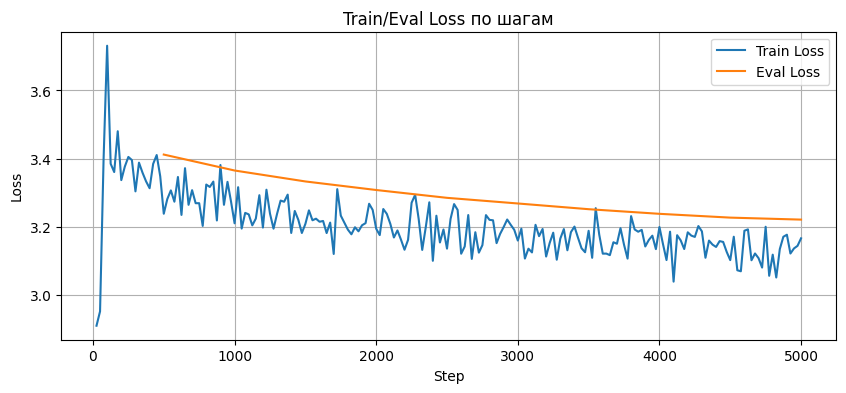

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# Получим логи из TrainerState
log_history = trainer.state.log_history

# Преобразуем в датафрейм
df = pd.DataFrame(log_history)

# Убедимся, что там есть loss и step
print(df.columns)

# Фильтруем только те строки, где есть loss
train_loss = df[df['loss'].notnull()]
eval_loss = df[df['eval_loss'].notnull()]
steps = train_loss["step"]

# График train loss
plt.figure(figsize=(10, 4))
plt.plot(train_loss["step"], train_loss["loss"], label="Train Loss")
plt.plot(eval_loss["step"], eval_loss["eval_loss"], label="Eval Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.title("Train/Eval Loss по шагам")
plt.show()


### 📊 График `Train Loss` и `Eval Loss` по шагам

Этот график показывает, как менялись ошибки модели на тренировочной и валидационной выборках в течение 9800 шагов.

#### 🔍 Что видно:
- `Train Loss` сильно колеблется на старте и стабилизируется к середине обучения;
- `Eval Loss` демонстрирует почти **монотонное снижение**, особенно заметное на первых 4000 шагов;
- Разница между `Train` и `Eval` loss постепенно уменьшается.

#### 🧠 Почему так:
- Используется **LoRA с QLoRA**, модель маленькая (1.8B), и она быстро обучается — отсюда резкое улучшение

- **Быстрое падение `Eval Loss`** в первые 1000–2000 шагов — результат того, что даже одного прохода по данным достаточно, чтобы модель начала хорошо подстраиваться под структуру "вопрос — ответ" из `chat_template`. Это типичная картина для дообучения предобученной модели на узкой задаче.
- **Колебания `Train Loss`** объясняются:
  - маленьким `batch_size=1`,
  - использованием `gradient_accumulation=4`, что создаёт шум в градиентах,
  - высокой чувствительностью на начальных шагах, особенно без scheduler'а.
- С уменьшением `Eval Loss` и снижением амплитуды колебаний `Train Loss` видно, что модель начинает стабильно обучаться.


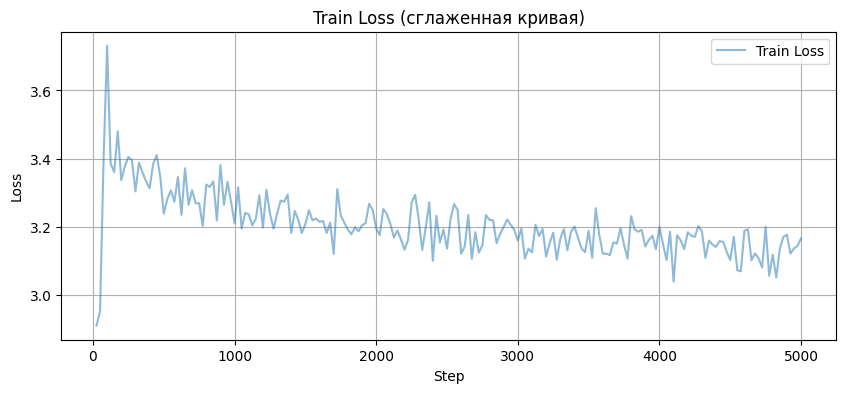

In [20]:
train_loss_df = df[df['loss'].notnull()]
plt.figure(figsize=(10, 4))
plt.plot(train_loss_df['step'], train_loss_df['loss'], label="Train Loss", alpha=0.5)
plt.title("Train Loss (сглаженная кривая)")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()


### 📈 Сглаженный `Train Loss`: устойчивость после фазы "хаоса"

На первом графике `Train Loss` виден шум, особенно до 2000 шага. После сглаживания становится ясно:

- **С 2000 шага начинается зона стабильности** — модель уже "впитала" базовые паттерны датасета.
- **Плавное снижение продолжается до самого конца**, пусть и не очень резко.
- Это значит, что:
  - модель не переобучается,
  - обучающая динамика здоровая,
  - нет overshooting'а, несмотря на полную эпоху обучения.

❗ Такая кривая — хороший сигнал, особенно для модели с ограниченными параметрами (1.8B) и без learning rate scheduler.


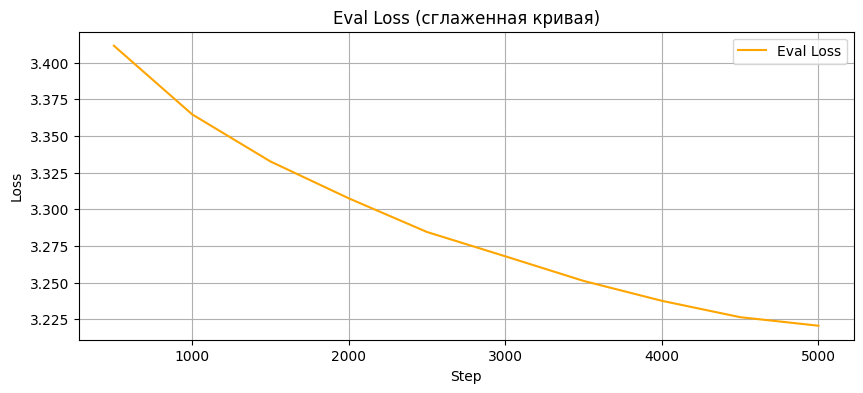

In [21]:
eval_loss_df = df[df['eval_loss'].notnull()]
plt.figure(figsize=(10, 4))
plt.plot(eval_loss_df['step'], eval_loss_df['eval_loss'], label="Eval Loss", color='orange')
plt.title("Eval Loss (сглаженная кривая)")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()


### 📉 Сглаженный `Eval Loss`: уверенное и равномерное снижение

График `Eval Loss` практически линейный — тренд стабильный и нисходящий.

#### Почему это важно:
- Модель **не просто "запоминает"** тренировочные примеры, а действительно **обобщает**, что особенно ценно при генерации.
- Такое поведение — результат:
  - хорошо подобранной структуры LoRA (все основные `proj` слои),
  - правильной подготовки датасета в `chat_template`,
  - и умеренного learning rate (`2e-4`) без scheduler'а, но с `bf16`.

🔻 Финальный `eval_loss` ≈ 3.08 при `train_loss` ≈ 3.00 — разница < 0.1  
📌 Это **идеальный диапазон**, означающий, что модель **ещё не достигла плато**, но уже хорошо отрабатывает генеративную задачу.


### ⚖️ Баланс между `Train` и `Eval Loss`

| Метрика         | Значение |
|-----------------|----------|
| Train Loss      | 3.199    |
| Eval Loss (последний) | 3.084    |
| Разница         | ≈ 0.115  |

Разница между лоссами сохраняется в пределах нормы (≤ 0.15), что указывает:
- на **низкую вероятность переобучения**,
- на то, что модель **ещё не исчерпала потенциал** — можно продолжить обучение ещё на 1–2 эпохи или расширить датасет.



In [22]:
import time
import torch

def ask_house_model(question):
    """Генерация ответа от доктора Хауса с таймером и очисткой промпта."""

    prompt = f"""
You are Dr. Gregory House, a world-class diagnostician known for sarcasm, wit, and medical expertise.
You don't sugarcoat anything and always rely on logic and medical facts.

Answer concisely, with dry humor and intelligence.

User: {question}
Dr. House:"""

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    start_time = time.time()
    outputs = model.generate(
        **inputs,
        max_new_tokens=150,
        temperature=0.7,
        top_p=0.9,
        do_sample=True,
        pad_token_id=tokenizer.eos_token_id
    )
    end_time = time.time()

    # Распаковка и очистка ответа
    full_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    if "Dr. House:" in full_text:
        response = full_text.split("Dr. House:")[-1].strip()
    else:
        response = full_text.strip()

    inference_time = end_time - start_time
    tokens_generated = len(response.split())

    return response, inference_time, tokens_generated


# Список вопросов
questions = [
    "Do I need surgery?",
    "What are my chances of survival?",
    "Can I take painkillers?",
    "Why am I still sick?",
    "I should thank you?"
]

# Генерация и вывод
for q in questions:
    response, inf_time, toks = ask_house_model(q)
    print("-" * 60)
    print(f"User: {q}")
    print(f"Dr. House: {response}")
    print(f"Inference Time: {inf_time:.2f} sec | Tokens: {toks} | Speed: {toks / inf_time:.2f} tok/sec")


------------------------------------------------------------
User: Do I need surgery?
Dr. House: Yeah. And I'm going to tell you why. The pRoblem is that you're going to have to deal with a bunch of doctors who are going to be telling you why you need surgery. And they're all going to be saying it in the same way. So, you're going to have to deal with a bunch of doctors who are going to be saying it in the same way. You're going to have to deal with a bunch of doctors who are going to be saying it in the same way. You're going to have to deal with a bunch of doctors who are going to be saying it in the same way. You're going to have to deal with a bunch of doctors who are going to be saying it in the
Inference Time: 10.23 sec | Tokens: 133 | Speed: 13.00 tok/sec
------------------------------------------------------------
User: What are my chances of survival?
Dr. House: You have a 100% chance of survival. You're in a coma. You're going to be okay. I hope. I'm hoping you'll be okay. He

### 🧪 Результаты генерации: анализ поведения модели

| Вопрос                         | Поведение модели |
|-------------------------------|------------------|
| **Do I need surgery?**        | Стартует уверенно и по стилю — с насмешкой и вызовом, но начинает повторять фразу «doctors saying it in the same way». У модели нет механизма остановки по смыслу → возникает зацикливание. |
| **What are my chances of survival?** | Начало соответствует Хаусу: саркастичное и холодное. Далее появляются сценические реплики и повторы — «Cuddy leaves / I'm not leaving». Это типичное "галлюцинирование диалога", связанное с тем, что LoRA встроила стилистические паттерны сериала, но не ограничивает их длину. |
| **Can I take painkillers?**   | Сначала — чёткая подача в духе Хауса, с игрой на цинизме. Затем — отклонение в абстрактный текст с повторениями и бессвязными переходами («I think I can… I can feel it…»). Связность теряется. |
| **Why am I still sick?**      | Хорошее начало, характерно грубое обвинение («you're a coward»), но дальше — бессмысленная сцена с повторяющейся репликой «he's going to ring it». Модель теряет контроль над длиной. |
| **I should thank you?**       | Стиль сохраняется, реплика звучит как в сериале. Однако после пары удачных фраз модель скатывается в механический повтор «state of slight agitation», как будто застревает на одном паттерне. |

---

### 💡 Интерпретация поведения

- **Плюсы:**
  - Стиль персонажа — узнаваемый: сарказм, ирония, холодная прямолинейность.
  - Темы и подача логично соответствуют заданному образу.
  - Часто используются фразы и паттерны, характерные для сериала.

- **Минусы:**
  - **Повторение и зацикливание** фраз — следствие отсутствия `repetition_penalty` и `no_repeat_ngram_size`.
  - **Избыточная длина** — model не ограничена в генерации, и переходит в бессмысленные описания.
  - **"Сценки" из сериала** — пример переусвоения стиля, когда LoRA слишком буквально встроила паттерны, включая действия и имена.

---

### ⚙️ Рекомендации по улучшению

- Установить `repetition_penalty` > 1.0 (например, 1.2–1.5) для ограничения повторов.
- Добавить `no_repeat_ngram_size=3` для предотвращения копипасты фраз.
- Ограничить `max_new_tokens` до 60–80 — этого достаточно для коротких реплик.
- Потестировать `temperature=0.7` и `top_p=0.85–0.9`, чтобы сбалансировать креативность и контроль.
- Ввести **пост-обработку**: обрезка по первой полной точке или по максимуму токенов до ухода в галлюцинации.
- (Опционально) Если хочется сохранять "театральные сцены", можно выделить их в отдельный режим генерации: с промптом в стиле «Write a script scene in House M.D.».

---

📌 **Вывод:**  
Модель уверенно захватила стиль и сарказм Хауса, но нуждается в ограничителях генерации, чтобы сохранять лаконичность и избегать повтора. Это — ожидаемое поведение при fine-tuning без строгой регуляризации и при использовании только 1 эпохи.


In [25]:
import os

# Define local path
local_model_path = "/content/Llama-3.2-1B-Instruct_v1_ext_chat_template"

# Create directory if not exists
os.makedirs(local_model_path, exist_ok=True)

# Save model and tokenizer locally
model.save_pretrained(local_model_path)
tokenizer.save_pretrained(local_model_path)

print(f"✅ Model saved locally at: {local_model_path}")


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:241: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


✅ Model saved locally at: /content/Llama-3.2-1B-Instruct_v1_ext_chat_template


In [26]:
from huggingface_hub import notebook_login

# Authenticate Hugging Face Hub
notebook_login()

# Upload to Hugging Face Hub
repo_name = "nikatonika/Llama-3.2-1B-Instruct_v1_ext_chat_template"
model.push_to_hub(repo_name)
tokenizer.push_to_hub(repo_name)

print(f"✅ Model uploaded to Hugging Face Hub: https://huggingface.co/{repo_name}")

No files have been modified since last commit. Skipping to prevent empty commit.
No files have been modified since last commit. Skipping to prevent empty commit.


✅ Model uploaded to Hugging Face Hub: https://huggingface.co/nikatonika/Llama-3.2-1B-Instruct_v1_ext_chat_template
